In [1]:
%%writefile task_07_utils.py

import numpy as np


def f(x):
    return 3*(x**2) + 2*x


def integral(x):
    return x**3 + x**2


def trapezoidal_rule_integral(x):
    y = f(x)
    y_right = y[1:]  # right values
    y_left = y[:-1]  # left values
    interval_size = (x[-1] - x[0]) / (len(x) - 1)
    
    return np.sum(y_right + y_left) * interval_size * 0.5

Overwriting task_07_utils.py


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from task_07_utils import f, integral, trapezoidal_rule_integral

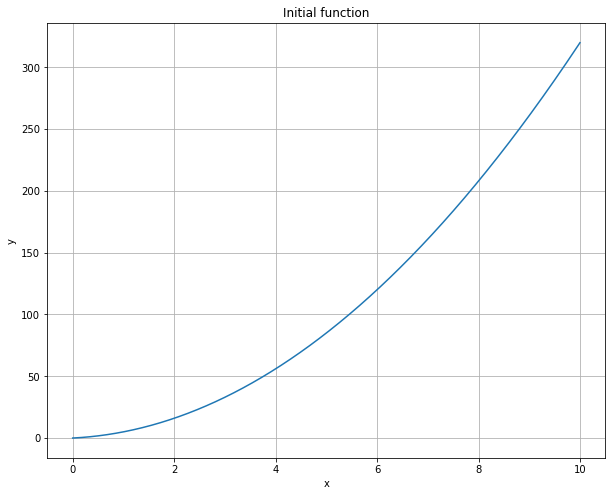

In [3]:
# limits
a, b = 0, 10 

x = np.linspace(a, b, 1000)
y = f(x)

theoretical_answer = integral(b) - integral(a)

plt.figure(figsize=(10, 8))
plt.plot(x, y)
plt.grid('on')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Initial function')

plt.show()

In [4]:
num_of_points = np.arange(2, 1001, 1, dtype=int)

integration_error = np.zeros(len(num_of_points), dtype=float)
discretization_size = np.zeros(len(num_of_points), dtype=float)

for i in num_of_points:
    samples, n = np.linspace(a, b, num=i, retstep=True)
    integration_error[i-2] = np.abs(trapezoidal_rule_integral(samples) - theoretical_answer)
    discretization_size[i-2] = n #(b - a) / (i - 1)

Text(0.5, 1.0, 'Integration error vs discretization step')

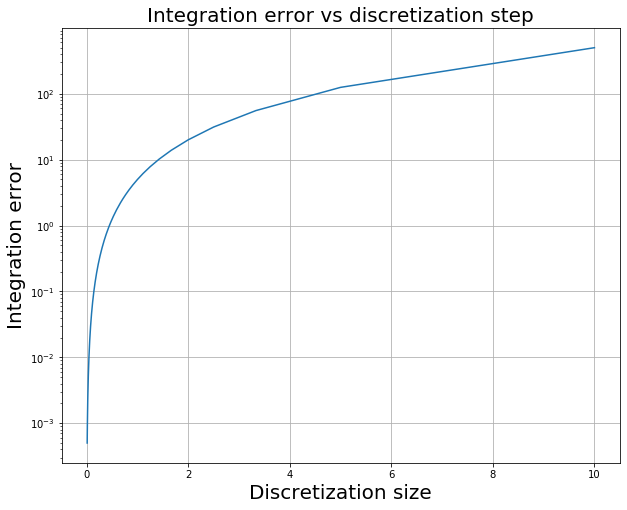

In [5]:
plt.figure(figsize=(10, 8))
plt.semilogy(discretization_size, integration_error)
plt.grid('on')
plt.xlabel('Discretization size', fontsize=20)
plt.ylabel('Integration error', fontsize=20)
plt.title('Integration error vs discretization step', fontsize=20)

### MPI

In [9]:
%%writefile task_07_integral.py

import os
import time
import numpy as np

from PIL import Image
from mpi4py import MPI
from task_07_utils import f, trapezoidal_rule_integral


comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

IS_ROOT = rank == 0
IS_SAVE = False

LOWER_BOUND = 0
UPPER_BOUND = 10
LINSPACE_SIZE = 1_000_000_000

samples = None
array_size = None

if IS_ROOT:
    samples = np.linspace(LOWER_BOUND, UPPER_BOUND, num=LINSPACE_SIZE, dtype=float)
    array_size = samples.size
    
array_size = comm.bcast(array_size, root=0)
num_data_per_rank = array_size // size

if IS_ROOT:
    num_data_per_rank =  array_size - (num_data_per_rank * (size - 1))

received = np.empty(num_data_per_rank, dtype=float)
sendcounts = np.array(comm.gather(num_data_per_rank, 0))

comm.Scatterv((samples, sendcounts), received, root=0)
received_calc = trapezoidal_rule_integral(received)

answer = comm.reduce(received_calc, op=MPI.SUM, root=0)

Overwriting task_07_integral.py


In [12]:
time_arr = []
processes = range(1, 11)
for i in processes:
    print(f'Num of processes: {i},\t', end='')
    t = %timeit -o -r 3 !mpirun -n {i} --allow-run-as-root --mca btl ^vader python3 task_07_integral.py
    time_arr.append(t.best)

Num of processes: 1,	12.1 s ± 43.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 2,	8.71 s ± 28.9 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 3,	7.48 s ± 24 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 4,	7.07 s ± 71.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 5,	6.79 s ± 40.9 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 6,	6.51 s ± 45.2 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 7,	6.46 s ± 46.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 8,	6.25 s ± 27.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 9,	6.16 s ± 38.2 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 10,	6.21 s ± 41.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Text(0.5, 1.0, 'SpeedUp vs Num of processes')

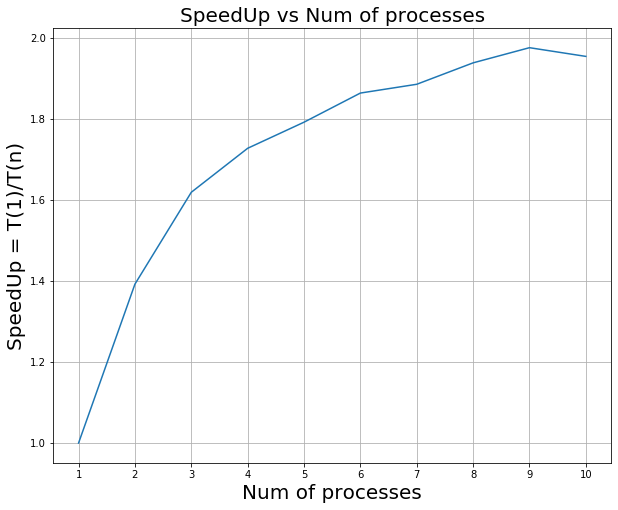

In [13]:
speedup = time_arr[0] / np.array(time_arr)

plt.figure(figsize=(10, 8))
plt.plot(processes, speedup)
plt.xticks(processes)
plt.xlabel('Num of processes', fontsize=20)
plt.ylabel('SpeedUp = T(1)/T(n)', fontsize=20)
plt.grid('on')
plt.title('SpeedUp vs Num of processes', fontsize=20)